In [16]:
import os,sys
sys.path.append(os.path.abspath(".."))

In [17]:
from core.modeling.base import BaseModel,Config
from core.modeling.dlrm import DLRMParams,DLRMState
import torch
import numpy as np
import pandas as pd
import torch.utils.data
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from core.data import load_ds,preprocess,normalize
from core.utils import seed_all, read_csv, to_csv
import seaborn as sns
import pathlib,json
sns.set_theme(style="darkgrid")
device = "cuda" if torch.cuda.is_available() else "cpu"
seed = 0
seed_all(seed)
new_model = False

In [18]:
paths = ["movies", "users", "ratings", "cols"]
def topath(p):
    return f"dlrm_ml_{p}.csv"
filename = "dlrm.pt"

In [19]:
# if not new_model and pathlib.Path(topath(paths[0])).exists():
#     movies, users, ratings, cols = [read_csv(topath(p)) for p in paths]
#     movie_cat_cols, movie_num_cols, user_cat_cols, user_num_cols = [json.loads(i) for i in cols[
#         ["movie_cat_cols", "movie_num_cols", "user_cat_cols", "user_num_cols"]
#     ].iloc[0].values.tolist()]
#     print("Loaded")
# else:
movies, ratings = load_ds(2_000_000, 2_000_000)
movies, users, movie_cols, user_cols = preprocess(movies, ratings)
(movie_cat_cols, movie_num_cols), (user_cat_cols,
                                    user_num_cols) = movie_cols, user_cols
cols = pd.DataFrame(dict(
    movie_cat_cols=json.dumps(movie_cat_cols),
    movie_num_cols=json.dumps(movie_num_cols),
    user_cat_cols=json.dumps(user_cat_cols),
    user_num_cols=json.dumps(user_num_cols),
),index=[0])
for df, p in zip([movies, users, ratings, cols], paths):
    to_csv(df,topath(p), index=False)


n_users = users.user.nunique()
n_movies = movies.movie.nunique()
extra = DLRMState(
    n_users=n_users,
    n_movies=n_movies,
    user_cat_cols=user_cat_cols,
    movie_cat_cols=movie_cat_cols,
    user_num_cols=user_num_cols,
    movie_num_cols=movie_num_cols,
    movies_path=topath("movies"),
    users_path=topath("users"),
)
# params.to_dict()

In [20]:
ratings.rename(columns={
    "movie":"__movieId",
    "user":"__userId",
},inplace=True)
# ratings
cat_cols = user_cat_cols + movie_cat_cols
users_nunique = users[user_cat_cols].nunique().tolist()
movies_nunique = movies[movie_cat_cols].nunique().tolist()
# movies_nunique[movie_cat_cols.index("movie")] = ratings.__movieId.nunique()

nunique = users_nunique + movies_nunique
num_cols = user_num_cols + movie_num_cols

In [21]:
ds = ratings.merge(movies, on="__movieId",).merge(users, how="left", on="__userId")
ds = normalize(ds, num_cols + ["rating"])
ds.drop(columns=["__movieId", "__userId"],inplace=True)
ds.head()
# nunique = ds.nunique()[user_cat_cols + movie_cat_cols].values

,rating,movie,movie_avg_rating,Sci-Fi,Mystery,Film-Noir,Documentary,IMAX,Drama,War,...,Thriller_user_rating,Romance_user_rating,Western_user_rating,Crime_user_rating,Action_user_rating,Fantasy_user_rating,Horror_user_rating,Children_user_rating,Adventure_user_rating,Animation_user_rating
0,0.8,16,0.777865,False,False,False,False,False,True,False,...,0.7,0.65,0.7,0.775,0.821053,0.5,0.733333,0.7,0.694118,0.0
1,0.2,24,0.742939,False,False,False,False,False,True,False,...,0.7,0.65,0.7,0.775,0.821053,0.5,0.733333,0.7,0.694118,0.0
2,0.4,28,0.798697,True,True,False,False,False,True,False,...,0.7,0.65,0.7,0.775,0.821053,0.5,0.733333,0.7,0.694118,0.0
3,1.0,29,0.756579,False,False,False,False,False,True,False,...,0.7,0.65,0.7,0.775,0.821053,0.5,0.733333,0.7,0.694118,0.0
4,1.0,31,0.785049,True,True,False,False,False,False,False,...,0.7,0.65,0.7,0.775,0.821053,0.5,0.733333,0.7,0.694118,0.0


In [22]:
ds[cat_cols] = ds[cat_cols].astype(np.int32)
ds[num_cols] = ds[num_cols].astype(np.float32)
ds["rating"] = ds["rating"].astype(np.float32)

In [23]:
class DS(torch.utils.data.Dataset):
    def __init__(
        self,
        num: pd.DataFrame,
        cat: pd.DataFrame,
        y: pd.DataFrame,
    ) -> None:
        super().__init__()
        self.num = num
        self.cat = cat
        self.y = y

    def __len__(self):
        l = self.num.shape[0]
        return l

    def __getitem__(self, index):
        num = self.num[index]
        cat = self.cat[index]
        y = self.y[index]
        # X,y
        return dict(num=num, cat=cat,y=y)

batch_size = 64*20
all_ds = DS(
    ds[num_cols].values,
    ds[cat_cols].values,
    ds.rating.values,
)
train_ds, valid_ds, test_ds = torch.utils.data.random_split(all_ds,[.8, .1, .1])
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size,shuffle=True)
_d=next(iter(train_dl))
_d["num"].dtype, _d["cat"].dtype, _d["y"].dtype

(torch.float32, torch.int32, torch.float32)

In [24]:
if not new_model and pathlib.Path(filename).exists():
    model,optimizer,training_result = BaseModel.load(
        filename,
    )
else:
    model = BaseModel.init_model(
        Config(
            model_name="DLRM",
            lr=.001,
            params=DLRMParams(
                bot_layers=[len(num_cols), 32*2],
                embds=[(n, 32*2) for n in nunique],
                top_layers=[32*2],
                bot_p=.2,
                top_p=.2,
            ),
            extra=extra.to_dict(),
        )
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), model.config.lr, weight_decay=0.01)
    training_result = None
# model
model.numel()*4/(1024**2)
# params.to_dict()

24.877197265625

In [25]:
epochs = 1
patience = 5
training_result = model.fit(
    optimizer,
    train_dl,   
    loss_fn=F.mse_loss,
    metric=root_mean_squared_error,
    epochs=epochs,
    val_ld=valid_dl,
    patience=patience,
    last_training_result=training_result
)

Epoch:  1, loss : 0.0333, val_loss: 0.0305: 100%|██████████| 1250/1250 [00:41<00:00, 29.84it/s]


Model saved.


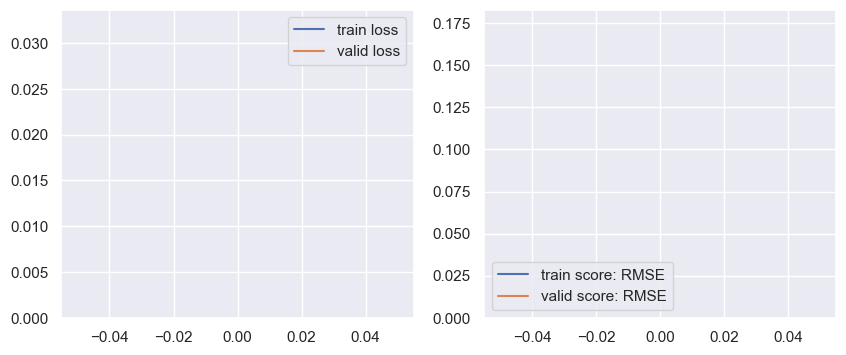

In [26]:
model.save(
    filename,
    optimizer=optimizer,
    last_training_result=training_result,
    extra=extra.to_dict(),
)
training_result.plot(score_name="RMSE")

In [27]:
test = test_ds[:None]
userIds = test["cat"][:, cat_cols.index("user")]
movieIds = test["cat"][:, cat_cols.index("movie")]
pred = model.recommend_for_users(
    users=userIds,
    movies=movieIds,
    **test,
    sort=False,
    wrap=False,
)
test = pd.DataFrame(dict(pred=pred,rating=test["y"],user=userIds,movie=movieIds))
test["rating"] =test["rating"] * 5 
test["error"] = test.rating - test.pred

print(f"True: mean {test.rating.mean():.3}, std {test.rating.std():.3}")
print(f"Pred: mean {test.pred.mean():.3}, std {test.pred.std():.3}")
print(f"RSME: {root_mean_squared_error(test.rating,test.pred)}")
test[["user", "movie", "rating", "pred", "error"]].head()

True: mean 3.54, std 1.07
Pred: mean 3.55, std 0.585
RSME: 0.8645370321814194


,user,movie,rating,pred,error
0,10822,21764,4.0,3.847170,0.152830
1,10821,1167,3.5,3.749898,-0.249898
2,10804,582,3.0,3.928986,-0.928986
3,2455,8201,5.0,4.150442,0.849558
4,587,8197,2.5,3.252175,-0.752175


In [28]:
test.rating.unique()

array([4. , 3.5, 3. , 5. , 2.5, 1. , 4.5, 0.5, 2. , 1.5], dtype=float32)

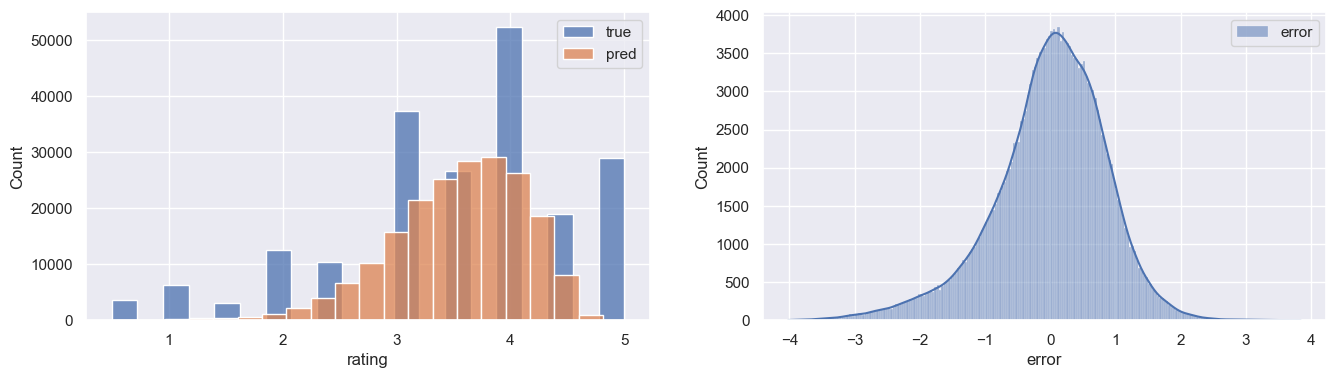

In [29]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.histplot(test.error, fill=True, label="error", ax=ax2, kde=True)

sns.histplot(test.rating, fill=True, label="true", ax=ax1, bins=20, kde=False)
sns.histplot(test.pred, fill=True, label="pred", ax=ax1, bins=20, kde=False)
ax1.legend()
ax2.legend()

In [30]:
model.recommend_for_users(**model.prepare(
    3,
    movieIds=[55, 300],
), sort=True)

[Recommendation(userId=3, movieId=300, predicted_rating=4.999999046325684),
 Recommendation(userId=3, movieId=55, predicted_rating=4.999988555908203)]